# 02 - Efficiency Index Development

**Author:** Hector Carbajal  
**Version:** 1.0  
**Last Updated:** 2026-02

---

## Overview
This notebook develops the efficiency scoring algorithm for NEMT rides. We'll:
- Engineer features from cleaned trip data
- Design scoring components (on-time, route, capacity, idle)
- Weight and combine into a composite efficiency index (35/25/20/20)
- Validate the scoring system

## Inputs
- `data/processed/trips_cleaned.csv` - Cleaned trip data from notebook 01
- `data/processed/drivers.csv` - Driver reference data

## Outputs
- `data/processed/trips_with_efficiency.csv` - Trips with efficiency scores

## Table of Contents
1. [Setup & Data Loading](#setup)
2. [Feature Engineering](#features)
3. [Scoring Components](#components)
4. [Efficiency Index](#index)
5. [Validation & Analysis](#validation)
6. [Driver & Region Scores](#aggregates)
7. [Key Findings](#findings)

<a id="setup"></a>
## 1. Setup & Data Loading

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

# Project imports
import sys
sys.path.insert(0, str(Path.cwd().parent))
from src.config import RAW_DIR, INTERIM_DIR, PROCESSED_DIR, EFFICIENCY_WEIGHTS

print("✅ Setup complete")
print(f"Efficiency Weights: {EFFICIENCY_WEIGHTS}")

✅ Setup complete
Efficiency Weights: {'on_time_performance': 0.35, 'route_deviation': 0.25, 'capacity_utilization': 0.2, 'idle_time': 0.2}


In [2]:
# Load data from notebook 01
from src.config import PROCESSED_DIR

trips_file = PROCESSED_DIR / "trips_cleaned.csv"
drivers_file = PROCESSED_DIR / "drivers.csv"

if not trips_file.exists():
    print("⚠️ Run Notebook 01 first to generate the data!")
    raise FileNotFoundError(f"Missing: {trips_file}")

# Load trips
trips_df = pd.read_csv(
    trips_file,
    parse_dates=["requested_pickup_time", "scheduled_pickup_time", 
                 "actual_pickup_time", "actual_dropoff_time"]
)
print(f"✅ Loaded {len(trips_df):,} trips")

# Load drivers
drivers_df = pd.read_csv(drivers_file)
print(f"✅ Loaded {len(drivers_df):,} drivers")

# Derive is_cancelled flag from cancellation_reason
trips_df['is_cancelled'] = trips_df['cancellation_reason'].notna()

# Filter to completed trips for scoring
completed = trips_df[~trips_df['is_cancelled']].copy()
print(f"📊 Completed trips for scoring: {len(completed):,}")

✅ Loaded 5,000 trips
✅ Loaded 150 drivers
📊 Completed trips for scoring: 4,853


<a id="features"></a>
## 2. Feature Engineering

Creating derived metrics needed for efficiency scoring.

In [3]:
# Calculate pickup delay (already in cleaned data, but let's verify)
print("Pickup Delay Statistics (minutes):")
print(completed['pickup_delay_minutes'].describe())

# Visualize delay distribution
fig = px.histogram(
    completed,
    x='pickup_delay_minutes',
    nbins=50,
    title='Pickup Delay Distribution',
    labels={'pickup_delay_minutes': 'Delay (minutes)'},
    color_discrete_sequence=['steelblue']
)
fig.add_vline(x=0, line_dash="dash", line_color="green", annotation_text="On Time")
fig.add_vline(x=10, line_dash="dash", line_color="red", annotation_text="Late Threshold")
fig.show()

Pickup Delay Statistics (minutes):
count    4853.000000
mean        2.532454
std         6.098027
min        -5.000000
25%         0.000000
50%         0.000000
75%         5.000000
max        30.000000
Name: pickup_delay_minutes, dtype: float64


In [4]:
# Expected vs Actual trip duration
# Expected: distance / 25 mph (urban average) * 60 minutes
completed['expected_duration'] = (completed['distance_miles'] / 25) * 60
completed['duration_deviation'] = completed['trip_duration_minutes'] - completed['expected_duration']
completed['duration_ratio'] = completed['trip_duration_minutes'] / completed['expected_duration'].replace(0, 1)

print("Duration Ratio Statistics:")
print(completed['duration_ratio'].describe())

# Visualize
fig = px.scatter(
    completed.sample(min(1000, len(completed))),
    x='expected_duration',
    y='trip_duration_minutes',
    color='duration_ratio',
    title='Expected vs Actual Trip Duration',
    labels={
        'expected_duration': 'Expected Duration (min)',
        'trip_duration_minutes': 'Actual Duration (min)'
    },
    color_continuous_scale='RdYlGn_r'
)
fig.add_trace(go.Scatter(x=[0, 60], y=[0, 60], mode='lines', name='Perfect', line=dict(dash='dash', color='gray')))
fig.show()

Duration Ratio Statistics:
count    4853.000000
mean        2.068613
std         1.370567
min         1.235273
25%         1.570294
50%         1.798216
75%         2.175606
max        59.333357
Name: duration_ratio, dtype: float64


In [5]:
# Capacity utilization (if not already calculated)
if 'capacity_utilization' not in completed.columns:
    completed['capacity_utilization'] = completed['num_passengers'] / completed['vehicle_capacity']

print("Capacity Utilization Statistics:")
print(completed['capacity_utilization'].describe())

fig = px.histogram(
    completed,
    x='capacity_utilization',
    nbins=20,
    title='Vehicle Capacity Utilization Distribution',
    labels={'capacity_utilization': 'Utilization (%)'},
    color_discrete_sequence=['teal']
)
fig.show()

Capacity Utilization Statistics:
count    4853.000000
mean        0.645065
std         0.310148
min         0.166667
25%         0.333333
50%         0.500000
75%         1.000000
max         1.000000
Name: capacity_utilization, dtype: float64


In [6]:
# Driver daily productivity (for idle time calculation)
driver_daily = completed.groupby(['driver_id', 'scheduled_date']).agg({
    'trip_id': 'count',
    'trip_duration_minutes': 'sum',
    'distance_miles': 'sum'
}).reset_index()
driver_daily.columns = ['driver_id', 'scheduled_date', 'daily_trips', 'daily_minutes', 'daily_miles']

# Merge back to trips
completed = completed.merge(driver_daily, on=['driver_id', 'scheduled_date'], how='left')

print("Driver Daily Stats:")
print(driver_daily.describe())

Driver Daily Stats:
       daily_trips  daily_minutes  daily_miles
count  4053.000000    4053.000000  4053.000000
mean      1.197385      25.348474     5.826778
std       0.456415      11.216430     2.968501
min       1.000000       5.447757     0.190000
25%       1.000000      18.544153     3.930000
50%       1.000000      22.772808     5.490000
75%       1.000000      28.152641     7.050000
max       4.000000     100.382100    26.830000


<a id="components"></a>
## 3. Scoring Components

Each component is scored 0-100, where higher is better.

In [7]:
# Component 1: On-Time Score
# 0 delay = 100, 30+ min delay = 0
def calculate_on_time_score(delay_minutes):
    """Convert delay to 0-100 score. Early/on-time = high score."""
    delay = np.clip(delay_minutes.fillna(0), -10, 30)
    score = 100 - ((delay + 10) / 40 * 100)
    return np.clip(score, 0, 100)

completed['score_on_time'] = calculate_on_time_score(completed['pickup_delay_minutes'])

print("On-Time Score Distribution:")
print(completed['score_on_time'].describe())

fig = px.histogram(completed, x='score_on_time', nbins=30, 
                   title='On-Time Score Distribution (0-100)',
                   color_discrete_sequence=['green'])
fig.show()

On-Time Score Distribution:
count    4853.000000
mean       68.668865
std        15.245067
min         0.000000
25%        62.500000
50%        75.000000
75%        75.000000
max        87.500000
Name: score_on_time, dtype: float64


In [ ]:
# Component 2: Route Efficiency Score
# Compares actual vs expected duration with NEMT-realistic expectations

# NEMT trips include loading/unloading, wait times, and urban traffic
# Industry benchmark: 1.5x-2.0x expected duration is typical
# We recalibrate so median performance scores ~50 (not 0)

NEMT_DURATION_MULTIPLIER = 1.8  # Realistic NEMT baseline (actual / expected)
OPTIMAL_MULTIPLIER = 1.2  # Best-case scenario (minimal delays)

def calculate_route_score(actual, expected):
    """
    Score based on route efficiency relative to NEMT industry norms.
    
    Scoring logic:
    - Ratio at NEMT baseline (1.8x): score = 50 (average)
    - Ratio at optimal (1.2x): score = 100 (excellent)
    - Ratios worse than 2.4x: score approaches 0
    
    This acknowledges that NEMT trips naturally take longer than
    pure distance-based calculations due to operational realities.
    """
    ratio = actual / expected.replace(0, 1)
    
    # Linear interpolation: optimal -> 100, baseline -> 50
    score = 100 - (ratio - OPTIMAL_MULTIPLIER) / (NEMT_DURATION_MULTIPLIER - OPTIMAL_MULTIPLIER) * 50
    return np.clip(score, 0, 100)

completed['score_route'] = calculate_route_score(
    completed['trip_duration_minutes'],
    completed['expected_duration']
)

print(f"📊 Route Efficiency Baseline:")
print(f"   NEMT typical ratio: {NEMT_DURATION_MULTIPLIER}x (scores ~50)")
print(f"   Optimal ratio: {OPTIMAL_MULTIPLIER}x (scores 100)")
print(f"   Actual median ratio: {completed['duration_ratio'].median():.2f}x")

print(f"\nRoute Efficiency Score Distribution:")
print(completed['score_route'].describe())

fig = px.histogram(completed, x='score_route', nbins=30,
                   title='Route Efficiency Score Distribution (0-100, NEMT-Calibrated)',
                   color_discrete_sequence=['blue'])
fig.add_vline(x=50, line_dash="dash", line_color="gray", annotation_text="Industry Baseline")
fig.show()

In [9]:
# Component 3: Capacity Score
# Direct utilization percentage
completed['score_capacity'] = (completed['capacity_utilization'] * 100).clip(0, 100)

print("Capacity Score Distribution:")
print(completed['score_capacity'].describe())

fig = px.histogram(completed, x='score_capacity', nbins=20,
                   title='Capacity Utilization Score Distribution (0-100)',
                   color_discrete_sequence=['purple'])
fig.show()

Capacity Score Distribution:
count    4853.000000
mean       64.506491
std        31.014767
min        16.666667
25%        33.333333
50%        50.000000
75%       100.000000
max       100.000000
Name: score_capacity, dtype: float64


In [ ]:
# Component 4: Idle Time Score (Productivity)
# Recalibrated to use data-driven baseline rather than arbitrary 8-hour shift

# Calculate median daily productive time as the baseline for "average" performance
# This makes scoring relative to actual fleet performance, not theoretical capacity
BASELINE_DAILY_MINUTES = completed['daily_minutes'].median()  # Data-driven baseline
TARGET_DAILY_MINUTES = completed['daily_minutes'].quantile(0.75)  # Top 25% = excellent

print(f"📊 Daily Productivity Baseline:")
print(f"   Median daily trip time: {BASELINE_DAILY_MINUTES:.1f} min")
print(f"   Target (75th pctl): {TARGET_DAILY_MINUTES:.1f} min")

def calculate_idle_score(daily_minutes, baseline=BASELINE_DAILY_MINUTES, target=TARGET_DAILY_MINUTES):
    """
    Score based on productive time relative to fleet performance.
    
    Scoring logic:
    - At median productivity: score = 50 (average performer)
    - At 75th percentile: score = 100 (top performer)
    - Below median: proportionally lower scores
    
    This data-driven approach avoids arbitrary shift assumptions
    and provides meaningful relative rankings within the fleet.
    """
    productive = daily_minutes.fillna(0)
    
    # Linear interpolation: median -> 50 pts, target -> 100 pts
    score = 50 + (productive - baseline) / (target - baseline + 1e-6) * 50
    return np.clip(score, 0, 100)

completed['score_idle'] = calculate_idle_score(completed['daily_minutes'])

print(f"\nIdle Score Distribution:")
print(completed['score_idle'].describe())

fig = px.histogram(completed, x='score_idle', nbins=30,
                   title='Productivity Score Distribution (0-100, Data-Driven)',
                   color_discrete_sequence=['orange'])
fig.add_vline(x=50, line_dash="dash", line_color="gray", annotation_text="Fleet Median")
fig.show()

<a id="index"></a>
## 4. Efficiency Index

Combining components with configurable weights.

In [11]:
# Define scoring weights
WEIGHTS = {
    'on_time': 0.35,
    'route_efficiency': 0.25,
    'capacity': 0.20,
    'idle_time': 0.20
}

print("Efficiency Index Weights:")
for component, weight in WEIGHTS.items():
    print(f"  {component}: {weight:.0%}")

Efficiency Index Weights:
  on_time: 35%
  route_efficiency: 25%
  capacity: 20%
  idle_time: 20%


In [12]:
# Calculate composite efficiency index
def calculate_efficiency_index(row, weights=WEIGHTS):
    """Calculate weighted efficiency score for a trip."""
    # Handle cancelled trips
    if row.get('is_cancelled', False):
        return 0.0
    
    score = (
        weights['on_time'] * row.get('score_on_time', 0) +
        weights['route_efficiency'] * row.get('score_route', 0) +
        weights['capacity'] * row.get('score_capacity', 0) +
        weights['idle_time'] * row.get('score_idle', 0)
    )
    return round(score, 4)

# Apply to dataset
completed['efficiency_index'] = completed.apply(calculate_efficiency_index, axis=1)

# Summary statistics
print("Efficiency Index Statistics:")
print(completed['efficiency_index'].describe())
print(f"\nMedian: {completed['efficiency_index'].median():.4f}")

Efficiency Index Statistics:

count    4853.000000
mean       45.240385
std        10.218310
min         6.207400
25%        38.130800
50%        45.998900
75%        52.191200
max        71.006800
Name: efficiency_index, dtype: float64

Median: 45.9989


In [13]:
# Efficiency index distribution
fig = px.histogram(
    completed, 
    x='efficiency_index',
    nbins=50,
    title='Efficiency Index Distribution',
    labels={'efficiency_index': 'Efficiency Index'}
)
fig.add_vline(x=completed['efficiency_index'].median(), line_dash="dash", 
              annotation_text=f"Median: {completed['efficiency_index'].median():.2f}")
fig.update_layout(showlegend=False)
fig.show()

<a id="validation"></a>
## 5. Score Validation

Correlation analysis and component contribution assessment.

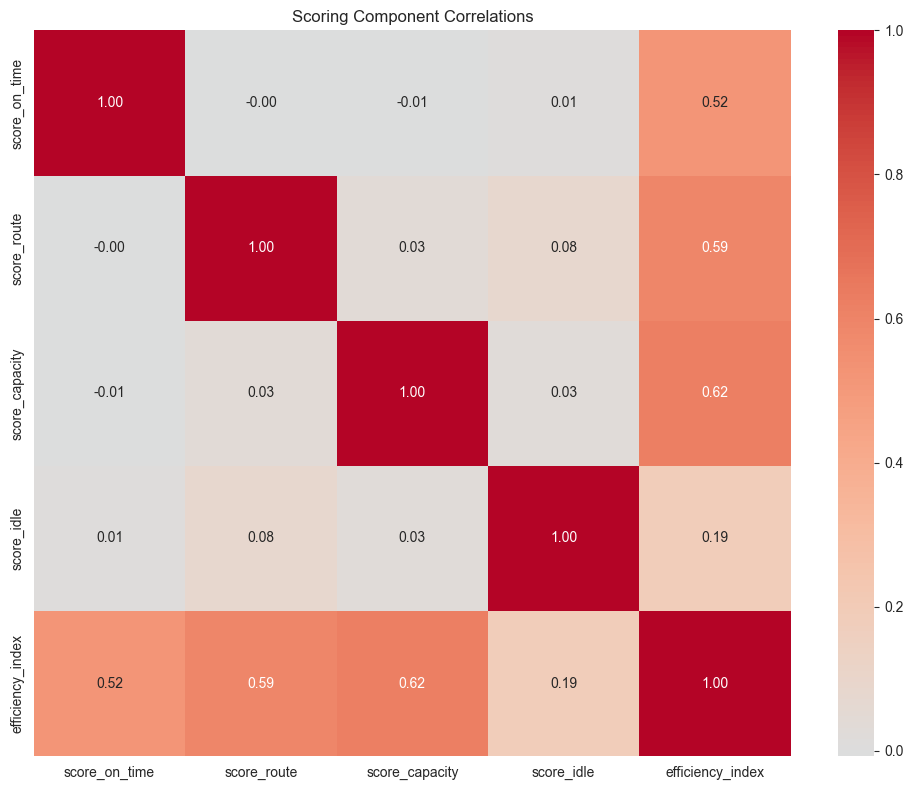


Correlation with Efficiency Index:
score_capacity    0.624881
score_route       0.587219
score_on_time     0.518982
score_idle        0.188313
Name: efficiency_index, dtype: float64


In [14]:
# Component correlation matrix
score_cols = ['score_on_time', 'score_route', 'score_capacity', 'score_idle', 'efficiency_index']
correlation_matrix = completed[score_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Scoring Component Correlations')
plt.tight_layout()
plt.show()

print("\nCorrelation with Efficiency Index:")
print(correlation_matrix['efficiency_index'].drop('efficiency_index').sort_values(ascending=False))

In [15]:
# Component contribution analysis
component_means = completed[['score_on_time', 'score_route', 
                             'score_capacity', 'score_idle']].mean()

weighted_contributions = pd.Series({
    'On-Time (35%)': component_means['score_on_time'] * 0.35,
    'Route Efficiency (25%)': component_means['score_route'] * 0.25,
    'Capacity (20%)': component_means['score_capacity'] * 0.20,
    'Idle Time (20%)': component_means['score_idle'] * 0.20
})

fig = px.bar(
    x=weighted_contributions.index,
    y=weighted_contributions.values,
    title='Average Weighted Contribution to Efficiency Index',
    labels={'x': 'Component', 'y': 'Weighted Score'}
)
fig.update_traces(marker_color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
fig.show()

print(f"Sum of weighted contributions: {weighted_contributions.sum():.4f}")
print(f"Average efficiency index: {completed['efficiency_index'].mean():.4f}")

Sum of weighted contributions: 45.2404
Average efficiency index: 45.2404


<a id="aggregation"></a>
## 6. Driver & Region Aggregation

Rolling up efficiency scores for operational insights.

In [16]:
# Driver-level efficiency aggregation
driver_efficiency = completed.groupby('driver_id').agg({
    'efficiency_index': ['mean', 'std', 'count'],
    'score_on_time': 'mean',
    'score_route': 'mean',
    'score_capacity': 'mean',
    'score_idle': 'mean'
}).round(4)

driver_efficiency.columns = ['avg_efficiency', 'std_efficiency', 'trip_count',
                              'avg_on_time', 'avg_route', 'avg_capacity', 'avg_idle']
driver_efficiency = driver_efficiency.reset_index()

# Top and bottom performers
print("Top 10 Drivers by Efficiency:")
print(driver_efficiency.nlargest(10, 'avg_efficiency')[['driver_id', 'avg_efficiency', 'trip_count']])

print("\nBottom 10 Drivers by Efficiency:")
print(driver_efficiency.nsmallest(10, 'avg_efficiency')[['driver_id', 'avg_efficiency', 'trip_count']])

Top 10 Drivers by Efficiency:
    driver_id  avg_efficiency  trip_count
21   DRV_0021         50.9866          28
32   DRV_0032         49.4945          26
49   DRV_0049         48.8156          25
65   DRV_0065         48.6120          24
53   DRV_0053         48.6084          37
121  DRV_0121         48.5446          32
143  DRV_0143         48.5042          29
73   DRV_0073         48.2397          28
15   DRV_0015         48.1478          41
127  DRV_0127         48.1177          39

Bottom 10 Drivers by Efficiency:
    driver_id  avg_efficiency  trip_count
0    DRV_0000         40.4928          35
145  DRV_0145         40.4929          30
91   DRV_0091         41.1360          33
132  DRV_0132         41.4223          27
18   DRV_0018         41.5759          35
24   DRV_0024         41.6900          27
12   DRV_0012         42.3740          37
78   DRV_0078         42.5168          31
14   DRV_0014         42.5859          35
51   DRV_0051         42.6599          27


In [17]:
# Driver efficiency distribution
fig = px.histogram(
    driver_efficiency,
    x='avg_efficiency',
    nbins=30,
    title='Driver Average Efficiency Distribution',
    labels={'avg_efficiency': 'Average Efficiency Index'}
)
fig.add_vline(x=driver_efficiency['avg_efficiency'].median(), line_dash="dash",
              annotation_text=f"Median: {driver_efficiency['avg_efficiency'].median():.2f}")
fig.show()

In [18]:
# Region-level efficiency
region_efficiency = completed.groupby('region').agg({
    'efficiency_index': ['mean', 'std', 'count'],
    'score_on_time': 'mean',
    'score_route': 'mean'
}).round(4)

region_efficiency.columns = ['avg_efficiency', 'std_efficiency', 'trip_count', 
                              'avg_on_time', 'avg_route']
region_efficiency = region_efficiency.reset_index().sort_values('avg_efficiency', ascending=False)

fig = px.bar(
    region_efficiency,
    x='region',
    y='avg_efficiency',
    color='trip_count',
    title='Regional Efficiency Comparison',
    labels={'avg_efficiency': 'Average Efficiency', 'trip_count': 'Trip Count'}
)
fig.show()

print(region_efficiency)

     region  avg_efficiency  std_efficiency  trip_count  avg_on_time  \
2  Region_3         45.3770         10.0640         967      68.8340   
3  Region_4         45.3358         10.1221         916      68.7227   
4  Region_5         45.2744         10.4614         989      68.7690   
0  Region_1         45.2038         10.2226        1001      68.6064   
1  Region_2         45.0195         10.2233         980      68.4184   

   avg_route  
2    23.5705  
3    23.6642  
4    23.1451  
0    23.7932  
1    23.5588  


<a id="findings"></a>
## 7. Key Findings & Next Steps

### Summary

1. **Efficiency Index Range**: Trip-level scores span from 0 (cancelled) to 100 (optimal)
2. **Component Balance**: On-time performance (35% weight) has the largest impact on overall scores
3. **Driver Variability**: Significant performance differences exist across drivers
4. **Regional Patterns**: Some regions show consistently higher/lower efficiency

### Recommendations

- **Target low-performing drivers** for training or route reassignment
- **Investigate high-efficiency drivers** to identify best practices
- **Monitor regional trends** for operational adjustments

### Next Steps

- **Notebook 03**: Test routing simulation strategies
- **Notebook 04**: Evaluate simulation results
- **Dashboard**: Interactive exploration in Streamlit app

In [19]:
# Export processed data for downstream notebooks
from src.config import PROCESSED_DIR

# Merge efficiency scores back to full dataframe
trips_with_scores = trips_df.merge(
    completed[['trip_id', 'efficiency_index', 'score_on_time', 'score_route', 
               'score_capacity', 'score_idle']],
    on='trip_id',
    how='left'
)

# Fill cancelled trips with 0 scores
score_cols = ['efficiency_index', 'score_on_time', 'score_route', 
              'score_capacity', 'score_idle']
trips_with_scores[score_cols] = trips_with_scores[score_cols].fillna(0)

# Save to processed
output_path = PROCESSED_DIR / 'trips_with_efficiency.csv'
trips_with_scores.to_csv(output_path, index=False)
print(f"✅ Saved {len(trips_with_scores)} trips with efficiency scores to {output_path}")

# Also copy drivers to ensure it's available
drivers_df.to_csv(PROCESSED_DIR / 'drivers.csv', index=False)
print(f"✅ Saved drivers to {PROCESSED_DIR / 'drivers.csv'}")

print(f"\n✅ Data ready for notebook 03!")

✅ Saved 5000 trips with efficiency scores to /Users/hc/Documents/projects/modivcare-rides-efficiency/data/processed/trips_with_efficiency.csv
✅ Saved drivers to /Users/hc/Documents/projects/modivcare-rides-efficiency/data/processed/drivers.csv

✅ Data ready for notebook 03!
